In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import wisardpkg as wp
from myEncoders import *

# biblioteca para paralelismo
from joblib import Parallel, delayed

Por efeito de apresentação, algumas célular precisaram ser re-rodadas e, como não foi fixada uma seed, alguns resultados presentes aqui podem estar diferentes dos apresentados em aula.

# Lendo os Dados

In [2]:
X_train = np.load('kmnist-train-imgs.npz')['arr_0'].reshape(60000, 28 * 28)
y_train = np.load('kmnist-train-labels.npz')['arr_0'].astype(str)

X_test = np.load('kmnist-test-imgs.npz')['arr_0'].reshape(10000, 28 * 28)
y_test = np.load('kmnist-test-labels.npz')['arr_0'].astype(str)

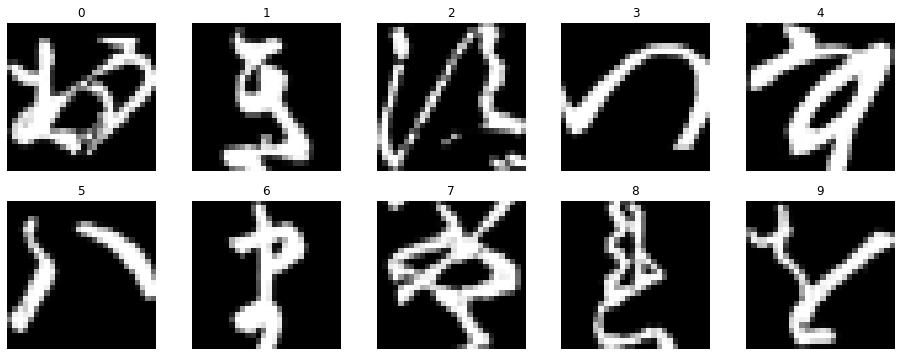

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[y_train==str(i)][i].reshape(28, 28), cmap='gray')
    ax.set_title(str(i))
    ax.set_axis_off()

In [4]:
%%time
def teste_threshold(n, t):
    decodedModel = DecodedModel(
        model = wp.Wisard(n),
        encoder = ThresholdEncoder(threshold = t)
    )
    decodedModel.fit(X_train, y_train)
    return decodedModel.score(X_test, y_test)

varia_t = Parallel(n_jobs = 8)(delayed(teste_threshold)(20, i) for i in range(1, 100, 2))
varia_n = Parallel(n_jobs = 8)(delayed(teste_threshold)(i, 10) for i in range(3, 45))

CPU times: user 234 ms, sys: 204 ms, total: 438 ms
Wall time: 42min 41s


Text(0, 0.5, 'Acurácia')

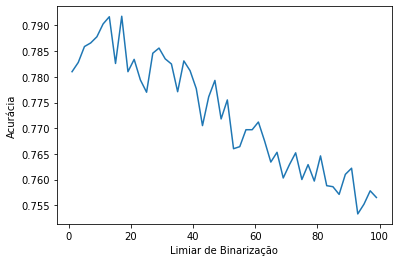

In [5]:
plt.plot(range(1, 100, 2), varia_t)
plt.xlabel("Limiar de Binarização")
plt.ylabel("Acurácia")

Text(0, 0.5, 'Acurácia')

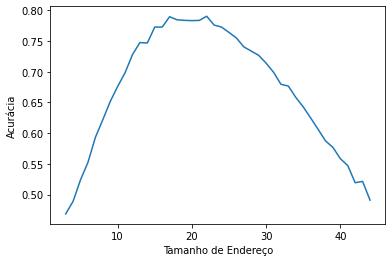

In [6]:
plt.plot(range(3, 45), varia_n)
plt.xlabel("Tamanho de Endereço")
plt.ylabel("Acurácia")

# Filtragem

In [7]:
n = 28 * 28
heat_matrix = np.diag(np.ones(n-28), 28) + \
    np.diag(np.ones(n-28), -28)

for i in range(28):
    heat_matrix[i*28:(i+1)*28, i*28:(i+1)*28] += np.diag(np.ones(27), -1)
    heat_matrix[i*28:(i+1)*28, i*28:(i+1)*28] += np.diag(np.ones(27), 1)


#heat_matrix += np.diag(heat_matrix.sum(1))
heat_matrix += np.diag(np.ones(n))

heat_matrix = (heat_matrix.T / heat_matrix.sum(1)).T

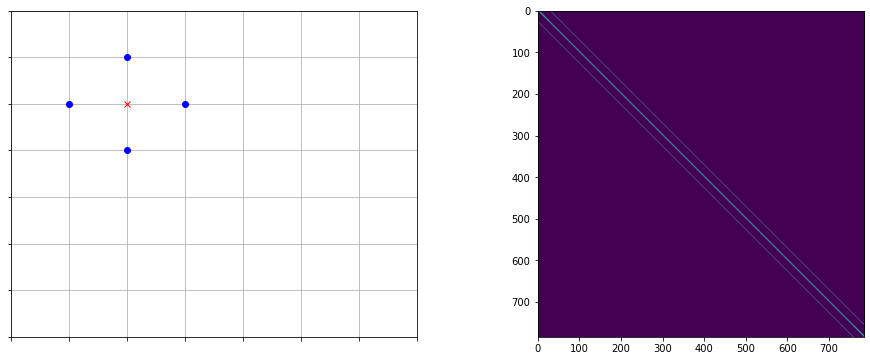

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

axes[0].plot([0], [0], 'xr')
axes[0].plot([-1, 1, 0, 0], [0, 0, -1, 1], 'ob')

axes[0].set_xlim([-2,  5])
axes[0].xaxis.set_ticks(range(-2, 6))
axes[0].xaxis.set_ticklabels([""] * 8)

axes[0].set_ylim([-5,  2])
axes[0].yaxis.set_ticks(range(-5, 3))
axes[0].yaxis.set_ticklabels([""] * 8)

axes[0].grid()

axes[1].imshow(heat_matrix)

fig.savefig('matriz-calor.svg')

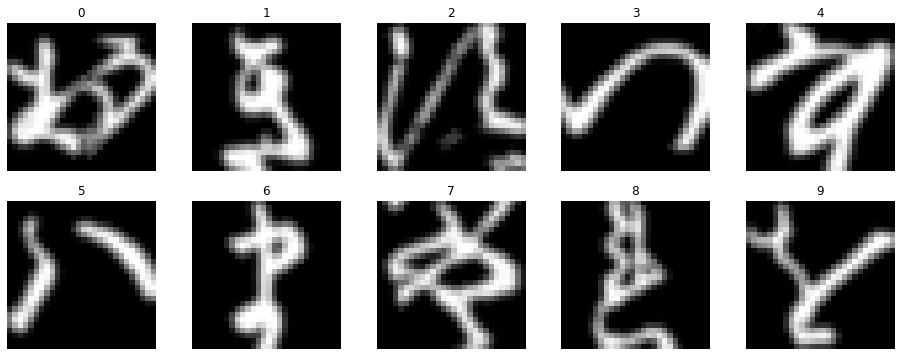

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow((heat_matrix @ X_train[y_train==str(i)][i].T).T.reshape(28, 28), cmap='gray')
    ax.set_title(str(i))
    ax.set_axis_off()

fig.savefig('filtro-aplicado.svg')

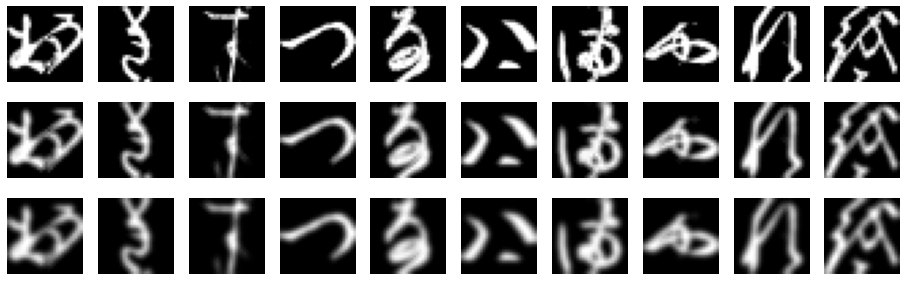

In [15]:
fig, axes = plt.subplots(3, 10, figsize=(16, 5))

for i in range(10):
    axes[0, i].imshow((X_train[y_train==str(i)][0]).reshape(28, 28), cmap='gray')
    axes[1, i].imshow((heat_matrix @ X_train[y_train==str(i)][0]).reshape(28, 28), cmap='gray')
    axes[2, i].imshow((heat_matrix @ heat_matrix @ X_train[y_train==str(i)][0]).reshape(28, 28), cmap='gray')

for ax in axes.flatten():
    ax.set_axis_off()

plt.savefig('aplicacao-filtro.svg')

# Termômetro Simples

In [16]:
%%time
def teste_termometro(n, s, filtro=0):
    decodedModel = DecodedModel(
        model = wp.Wisard(n),
        encoder = ThermometerEncoder(minimum = 0, maximum = 255, steps=s)
    )
    
    M = np.linalg.matrix_power(heat_matrix, filtro)
    decodedModel.fit((M @ X_train.T).T, y_train)
    return decodedModel.score((M @ X_test.T).T, y_test)

varia_s = Parallel(n_jobs = 8)(delayed(teste_termometro)(20, i, 0) for i in range(3, 16))
varia_n = Parallel(n_jobs = 8)(delayed(teste_termometro)(i, 5) for i in range(3, 40, 5))

CPU times: user 191 ms, sys: 302 ms, total: 493 ms
Wall time: 1h 28min 16s


Text(0, 0.5, 'Acurácia')

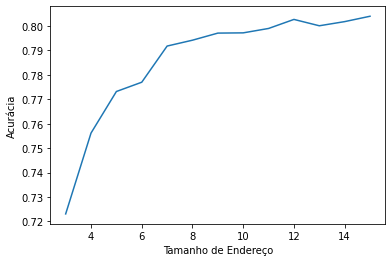

In [17]:
plt.plot(range(3, 16), varia_s)
plt.xlabel("Tamanho de Endereço")
plt.ylabel("Acurácia")

Text(0, 0.5, 'Acurácia')

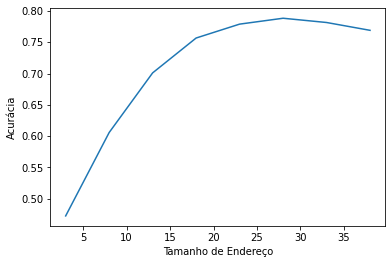

In [18]:
plt.plot(range(3, 40, 5), varia_n)
plt.xlabel("Tamanho de Endereço")
plt.ylabel("Acurácia")

# Termômetro Adaptativo por Variância

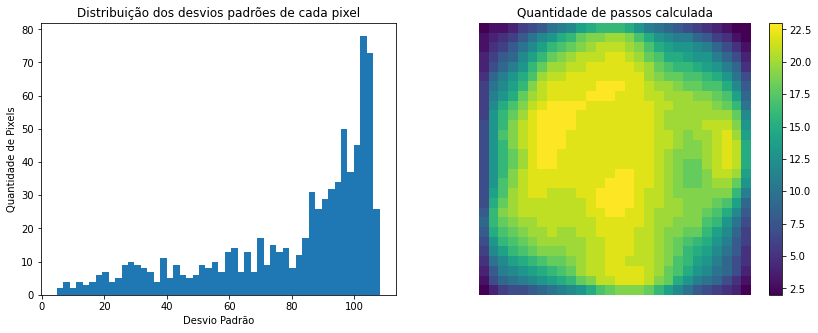

In [19]:
encoder = AdaptativeThermometerEncoder(X_train)

fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0].hist(encoder.std, bins = 50);
axes[0].set_title("Distribuição dos desvios padrões de cada pixel")
axes[0].set_ylabel('Quantidade de Pixels')
axes[0].set_xlabel('Desvio Padrão')

im = axes[1].imshow(encoder.steps.reshape(28, 28).reshape(28, 28))
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Quantidade de passos calculada")
axes[1].set_axis_off()

plt.savefig('term-adap.svg')

# Termômetro Percentil

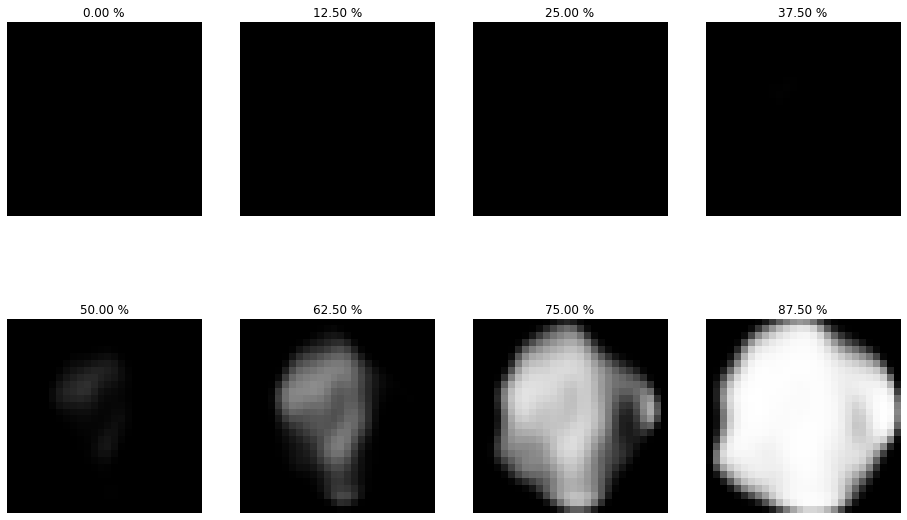

In [20]:
X_train_filter = (np.linalg.matrix_power(heat_matrix, 0) @ X_train.T).T

percentiles = np.linspace(0, 100, 8, endpoint=False)
percentile_images = np.array([
    np.percentile(X_train_filter, i, 0) for i in percentiles
])

fig, axes = plt.subplots(2, 4, figsize=(16, 10))

for ax, p, i in zip(axes.flatten(), percentiles, percentile_images):
    ax.imshow(i.reshape(28, 28), cmap='gray', vmin=0, vmax=255)
    ax.set_axis_off()
    ax.set_title("{:.2f} %".format(p))

plt.savefig('term-perc.svg')

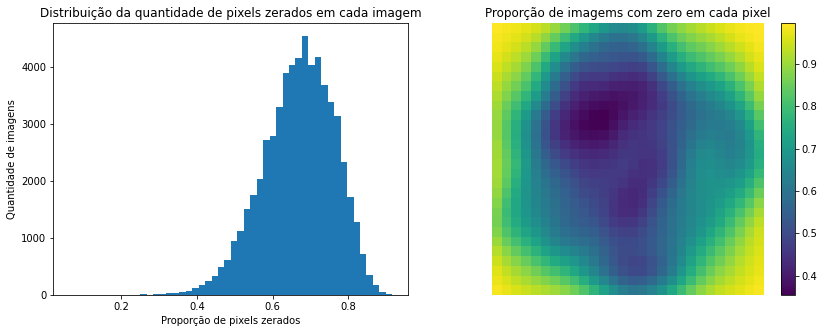

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0].hist((X_train == 0).mean(1), bins = 50);
axes[0].set_title("Distribuição da quantidade de pixels zerados em cada imagem")
axes[0].set_ylabel('Quantidade de imagens')
axes[0].set_xlabel('Proporção de pixels zerados')

im = axes[1].imshow((X_train == 0).mean(0).reshape(28, 28))
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Proporção de imagems com zero em cada pixel")
axes[1].set_axis_off()

plt.savefig('dist-pixel-0.svg')

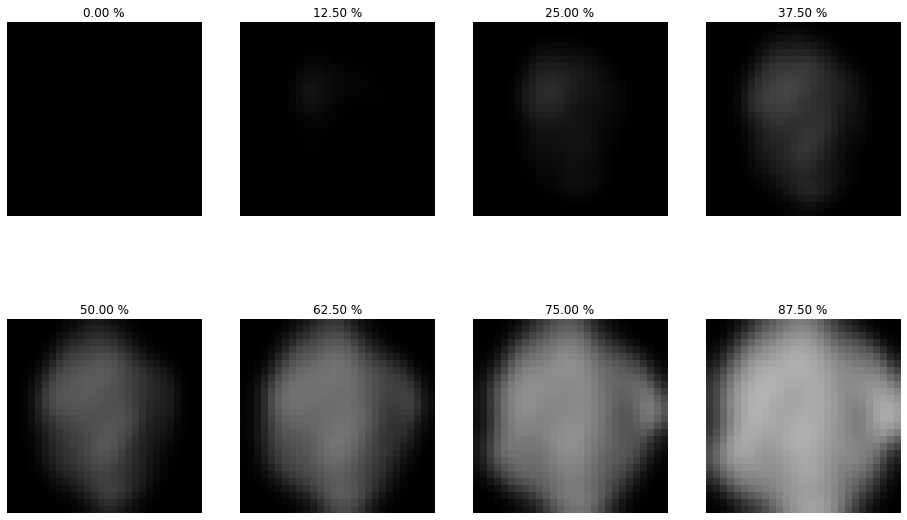

In [22]:
X_train_filter = (np.linalg.matrix_power(heat_matrix, 5) @ X_train.T).T

percentiles = np.linspace(0, 100, 8, endpoint=False)
percentile_images = np.array([
    np.percentile(X_train_filter, i, 0) for i in percentiles
])

fig, axes = plt.subplots(2, 4, figsize=(16, 10))

for ax, p, i in zip(axes.flatten(), percentiles, percentile_images):
    ax.imshow(i.reshape(28, 28), cmap='gray', vmin=0, vmax=255)
    ax.set_axis_off()
    ax.set_title("{:.2f} %".format(p))

plt.savefig('term-perc5.svg')

# Resultados

In [23]:
def teste_variancia(n, filtro=0):
    M = np.linalg.matrix_power(heat_matrix, filtro)
    X = (M @ X_train.T).T
    
    decodedModel = DecodedModel(
        model = wp.Wisard(n),
        encoder = AdaptativeThermometerEncoder(X)
    )
    decodedModel.fit(X, y_train)
    return decodedModel.score((M @ X_test.T).T, y_test)

def teste_percentil(n, s, filtro=0):
    M = np.linalg.matrix_power(heat_matrix, filtro)
    X = (M @ X_train.T).T
    
    decodedModel = DecodedModel(
        model = wp.Wisard(n),
        encoder = PercentileThermometerEncoder(steps = s, X = X)
    )
    decodedModel.fit(X, y_train)
    return decodedModel.score((M @ X_test.T).T, y_test)

In [24]:
%%time
simples = Parallel(n_jobs = 5)(delayed(teste_termometro)(20, 15, i) for i in [0, 1, 2, 5, 10])

CPU times: user 108 ms, sys: 119 ms, total: 226 ms
Wall time: 43min 46s


In [25]:
%%time
variancia = Parallel(n_jobs = 5)(delayed(teste_variancia)(20, i) for i in [0, 1, 2, 5, 10])

CPU times: user 347 ms, sys: 220 ms, total: 567 ms
Wall time: 44min 14s


In [26]:
%%time
percentil = Parallel(n_jobs = 5)(delayed(teste_percentil)(20, 15, i) for i in [0, 1, 2, 5, 10])

CPU times: user 88.4 ms, sys: 232 ms, total: 320 ms
Wall time: 42min 53s


In [27]:
%%time
percentil5 = Parallel(n_jobs = 5)(delayed(teste_percentil)(20, 5, i) for i in [0, 1, 2, 5, 10])

CPU times: user 31.1 ms, sys: 41 ms, total: 72.1 ms
Wall time: 14min 15s


In [29]:
import pandas as pd

pd.DataFrame(np.array([
    [0, 1, 2, 5, 10],
    simples,
    variancia,
    percentil5,
    percentil
]).T, columns = ["Filtro", "Simples", "Variância", "Percentil (15 passos)", "Percentil (5 passos)"])

,Filtro,Simples,Variância,Percentil (15 passos),Percentil (5 passos)
0,0.0,0.8033,0.8140,0.5339,0.6362
1,1.0,0.8235,0.8305,0.7242,0.7920
2,2.0,0.8260,0.8300,0.7942,0.8320
3,5.0,0.8229,0.8033,0.8289,0.8409
4,10.0,0.8013,0.7308,0.8177,0.8291
